In [1]:
import numpy as np
import random
import math
import copy
from YenAlgorithm import YenAlgorithm

class Genome(object):
    def __init__(self):
        self.path = []
        self.fitness = float('inf')

class GA:

    def __init__(self, src, dst, N, Max, K_paths, Pc, Pm, Ts):
        self.switches = [i for i in range(1,61)]
        self.src= src
        self.dst = dst
        self.weight_map= self.GetWeightMap()
        self.adjacency = copy.deepcopy(self.weight_map)
        self.N = N
        self.Max = Max
        self.Pm = Pm
        self.Pc = Pc
        self.K_paths = K_paths
        self.population = [self.CreateGenome() for i in range(self.N)]
        self.condidates = []
        self.best = []
        self.Ts = Ts
    
    def GetWeightMap(self):
        weight_map={}
        temp = 0
        with open('metric_data_60.txt') as f:
            for line in f:
                strt = line
                strt2 = strt.split(':')
                my_result = list(map(int, strt2[0].split(',')))
                if (temp!=my_result[0]):
                    weight_map[my_result[0]]={}
                weight_map[my_result[0]][my_result[1]] = int(strt2[1])
                temp = my_result[0]
        return weight_map

    def CreateGenome(self):
        newGenome = Genome()
        newGenome.path.append(self.src)
        current_switch = self.src
        while(current_switch!=self.dst):
            neighbor_switches = set(self.adjacency[current_switch].keys())-set(newGenome.path)
            neighbor_switches = list(neighbor_switches)
            if(len(neighbor_switches)==0):
                newGenome.path.clear()
                current_switch = self.src
                newGenome.path.append(self.src)
            else:
                next_switch = random.choice(neighbor_switches)
                newGenome.path.append(next_switch)
                current_switch = next_switch
        newGenome.fitness = self.Evaluate(newGenome.path)
        return newGenome

    def Evaluate(self,path):
        calculatedFitness = 0
        for i in range(len(path) - 1):
            p1 = path[i]
            p2 = path[i + 1]
            calculatedFitness += self.weight_map[p1][p2]
        return calculatedFitness
    
    def CorrectGenome(self,genome):
        dk = False
        for i in range(1,len(genome.path)-2):
            for j in range(i+1,len(genome.path)-1):
                if(genome.path[i]==genome.path[j]):
                    del genome.path[i+1:j+1]
                    dk = True
                    break
            if(dk==True):
                break
        return genome
    
    def ExchangeGenes(self, parents_1, parents_2):
        dk = False
        for i in range(1,len(parents_1.path)-1):
            for j in range(1,len(parents_2.path)-1):
                if(parents_1.path[i]==parents_2.path[j]):
                    tail_1 = copy.deepcopy(parents_1.path[i+1:])
                    tail_2 = copy.deepcopy(parents_2.path[j+1:])
                    del parents_1.path[i+1:]
                    del parents_2.path[j+1:]
                    parents_1.path.extend(tail_2)
                    parents_2.path.extend(tail_1)
                    dk = True
                    break
            if(dk==True):
                break
        return parents_1, parents_2
    
    def Crossover(self):
        children = []
        for i in range(0,self.N,2):
            father = random.randint(0,self.N-1)
            mother = random.randint(0,self.N-1)
            parents_1 = copy.deepcopy(self.population[father])
            parents_2 = copy.deepcopy(self.population[mother])
            if random.uniform(0,1) < self.Pc:
                child_1, child_2 = self.ExchangeGenes(parents_1, parents_2)
                child_1 = self.CorrectGenome(child_1)
                child_2  = self.CorrectGenome(child_2 )
                child_1.fitness = self.Evaluate(child_1.path)
                child_2.fitness = self.Evaluate(child_2.path)
                children.append(copy.deepcopy(child_1))
                children.append(copy.deepcopy(child_2))
            else:
                children.append(copy.deepcopy(parents_1))
                children.append(copy.deepcopy(parents_2))
        self.population = copy.deepcopy(children)
    
    def Mutation(self):
        for i in range(len(self.population)):
            if random.uniform(0,1) < self.Pm:
                parents = copy.deepcopy(self.population[i]) 
                ls = list(range(1,len(parents.path)-1))
                point_mutation = random.choice(ls)
                current_switch = parents.path[point_mutation]
                del parents.path[point_mutation+1:]
                while(current_switch!=self.dst):
                    neighbor_switches = set(self.adjacency[current_switch].keys())
                    neighbor_switches = list(neighbor_switches)
                    next_switch = random.choice(neighbor_switches)
                    parents.path.append(next_switch)
                    current_switch = next_switch
                parents.fitness = self.Evaluate(parents.path)
                self.population[i] = copy.deepcopy(parents)
                
    def Selection(self):
        selected_population=[]
        for i in range(self.N):
            selected_index = np.random.randint(0,len(self.population)-1)
            for ix in np.random.randint(0,len(self.population)-1,self.Ts-1):
                if(self.population[ix].fitness<self.population[selected_index].fitness):
                    selected_index = ix
            selected_population.append(self.population[selected_index])
        self.population = copy.deepcopy(selected_population)
    
    def MemorizeCondidates(self):
        self.population.sort(key=lambda x: x.fitness)
        condidate = []
        k=0
        for i in range(len(self.population)):
            dk_3 = False
            for genome in condidate:
                if(tuple(genome.path)==tuple(self.population[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                condidate.append(copy.deepcopy(self.population[i]))
                k=k+1
            if(k==self.K_paths):
                break
        self.condidates.extend(copy.deepcopy(condidate))
    
    def GetBest(self):
        self.condidates.sort(key=lambda x: x.fitness)
        self.best.clear()
        k=0
        for i in range(len(self.condidates)):
            dk_3 = False
            for genome in self.best:
                if(tuple(genome.path)==tuple(self.condidates[i].path)):
                    dk_3 = True
                    break
            if(dk_3!=True):
                self.best.append(copy.deepcopy(self.condidates[i]))
                k=k+1
            if(k==self.K_paths):
                break
    
    def Do(self):
        for i in range(self.Max):
            self.Crossover()
            self.Mutation()
            self.Selection()
            self.MemorizeCondidates()
        self.GetBest()

In [2]:
Times = 100
N = 50
Max = 50
K_paths = 10
Pc = 0.8
Pm = [0.05,0.5,0.95]
Ts = 5

In [3]:
weight_map={}
temp = 0
with open('metric_data_60.txt') as f:
    for line in f:
        strt = line
        strt2 = strt.split(':')
        my_result = list(map(int, strt2[0].split(',')))
        if (temp!=my_result[0]):
            weight_map[my_result[0]]={}
        weight_map[my_result[0]][my_result[1]] = int(strt2[1])
        temp = my_result[0]
        
vertices = [i for i in range(1,61)]
alg_y = YenAlgorithm(weight_map,vertices,11,50,K_paths)
paths_vertices = alg_y.compute_shortest_paths()

In [4]:
solan_1 = np.zeros(K_paths)
solan_2 = np.zeros(K_paths)
solan_3 = np.zeros(K_paths)
CD_1 = []
CD_2 = []
CD_3 = []

for i in range(Times):
    alg_1 = GA(11,50,N, Max, K_paths, Pc, Pm[0], Ts)
    alg_1.Do()
    for j in range(len(alg_1.best)):
        if(tuple(alg_1.best[j].path)==tuple(paths_vertices[j])):
            solan_1[j]+=1
    s = 0
    for member in alg_1.best:
        for i in range(len(member.path)-1):
            s+= alg_1.weight_map[member.path[i]][member.path[i+1]]
    CD_1.append(s)
            
    alg_2 = GA(11,50,N, Max, K_paths, Pc, Pm[1], Ts)
    alg_2.Do()
    for j in range(len(alg_2.best)):
        if(tuple(alg_2.best[j].path)==tuple(paths_vertices[j])):
            solan_2[j]+=1
    s = 0
    for member in alg_2.best:
        for i in range(len(member.path)-1):
            s+= alg_2.weight_map[member.path[i]][member.path[i+1]]
    CD_2.append(s)
    
    alg_3 = GA(11,50,N, Max, K_paths, Pc, Pm[2], Ts)
    alg_3.Do()
    for j in range(len(alg_3.best)):
        if(tuple(alg_3.best[j].path)==tuple(paths_vertices[j])):
            solan_3[j]+=1
    s = 0
    for member in alg_3.best:
        for i in range(len(member.path)-1):
            s+= alg_3.weight_map[member.path[i]][member.path[i+1]]
    CD_3.append(s)

In [5]:
print(solan_1)
print(solan_2)
print(solan_3)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[3. 0. 0. 1. 1. 0. 0. 0. 0. 0.]


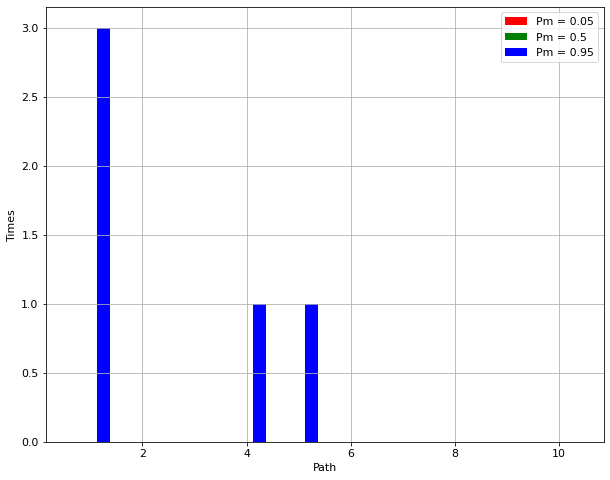

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size'   : 11}
matplotlib.rc('font', **font)
# create data
x = np.arange(10)+1
width = 0.25
  
# plot data in grouped manner of bar type
fig = plt.figure(figsize=(10,8))
plt.bar(x-0.25, solan_1, width, color='red')
plt.bar(x, solan_2, width, color='green')
plt.bar(x+0.25, solan_3, width, color='blue')
plt.xlabel("Path")
plt.ylabel("Times")
plt.legend(["Pm = "+str(Pm[0]), "Pm = "+str(Pm[1]), "Pm = "+str(Pm[2])])
plt.grid()
plt.savefig("GA_Pm_3.png",dpi=200)

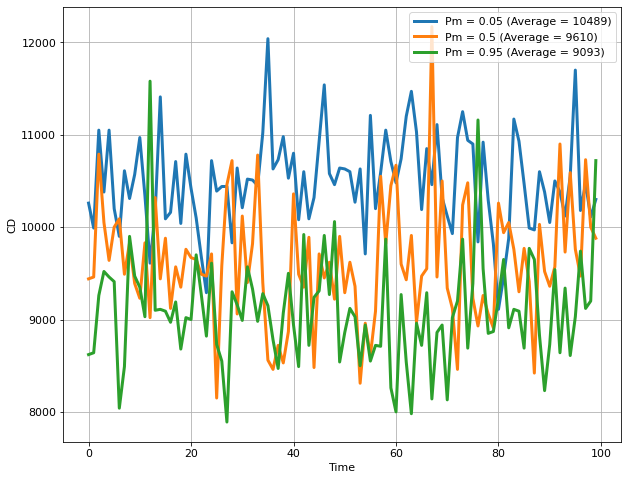

In [7]:
figg1 = plt.figure(figsize=(10,8))
avr_1 = int(sum(CD_1)/Times)
avr_2 = int(sum(CD_2)/Times)
avr_3 = int(sum(CD_3)/Times)
plt.plot(CD_1, label = "Pm = "+str(Pm[0])+ " (Average = "+str(avr_1)+")", linewidth = '3')
plt.plot(CD_2, label = "Pm = "+str(Pm[1])+ " (Average = "+str(avr_2)+")", linewidth = '3')
plt.plot(CD_3, label = "Pm = "+str(Pm[2])+ " (Average = "+str(avr_3)+")", linewidth = '3')
plt.legend(loc="upper right")
plt.xlabel("Time")
plt.ylabel("CD")
plt.grid()
plt.savefig("GA_Pm_3_2.png",dpi=200)